In [6]:
# Import necessary libraries
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from sklearn.preprocessing import label_binarize, minmax_scale
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay,
)


import matplotlib.pyplot as plt


In [7]:
# Face detection and recognition imports (adjust these paths based on your environment)
from face_alignment.alignment import norm_crop
from face_detection.scrfd.detector import SCRFD
from face_recognition.arcface.model import iresnet_inference
from face_recognition.arcface.utils import compare_encodings, read_features

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize face detector and recognizer
detector = SCRFD(model_file="face_detection/scrfd/weights/scrfd_2.5g_bnkps.onnx")
recognizer = iresnet_inference(model_name="r100", path="face_recognition/arcface/weights/arcface_r100.pth", device=device)

# Load precomputed face features and names
images_names, images_embs = read_features(feature_path="./datasets/face_features/feature")

# Set relative paths for train and test directories
train_directory = './trainNew'
test_directory = './testNew'


d:\SOP LOP DOP\Face recog\Face-Recognition-advance-main\face_recognition\arcface\model.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(path, map_lo

In [9]:
def get_feature(face_image):
    """
    Extract features from a face image.

    Args:
        face_image: The input face image.

    Returns:
        numpy.ndarray: The extracted features.
    """
    # Preprocessing steps
    face_preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((112, 112)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )
    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
    face_image = face_preprocess(face_image).unsqueeze(0).to(device)

    # Inference to get feature
    emb_img_face = recognizer(face_image).detach().cpu().numpy()
    images_emb = emb_img_face / np.linalg.norm(emb_img_face)
    return images_emb

def recognition(face_image):
    """
    Recognize a face image.

    Args:
        face_image: The input face image.

    Returns:
        tuple: A tuple containing the recognition score and name.
    """
    query_emb = get_feature(face_image)
    score, id_min = compare_encodings(query_emb, images_embs)
    name = images_names[id_min]
    score = score[0]
    return score, name


In [10]:
def evaluate_on_test_images(max_images_per_class=10):
    """
    Evaluate the model on test images, display the confusion matrix,
    and generate the precision-recall curve.

    Args:
        max_images_per_class (int): Maximum number of images to process per class.
    """
    # Check if the test directory exists
    if not os.path.exists(test_directory):
        print(f"Test directory not found: {test_directory}")
        return

    # Initialize lists for true and predicted labels, and predicted scores
    true_labels = []
    predicted_labels = []
    predicted_scores = []

    # Create a mapping for anonymized names
    class_to_person_map = {}
    anonymized_index = 1

    # Iterate over each class in the test directory
    for cls in os.listdir(test_directory):
        cls_path = os.path.join(test_directory, cls)
        if not os.path.isdir(cls_path):
            continue

        # Assign anonymized names if not already mapped
        if cls not in class_to_person_map:
            class_to_person_map[cls] = f"Person{anonymized_index}"
            anonymized_index += 1

        # List all images in the current class directory and limit to max_images_per_class
        images = os.listdir(cls_path)[:max_images_per_class]

        for image_file in images:
            image_path = os.path.join(cls_path, image_file)
            frame = cv2.imread(image_path)

            # Perform face detection
            outputs, img_info, bboxes, landmarks = detector.detect_tracking(image=frame)

            if outputs is not None and len(bboxes) > 0:
                # For simplicity, we'll assume one face per image
                # Crop and normalize the face
                face_image = norm_crop(frame, landmarks[0])
                score, predicted_name = recognition(face_image)

                # Ground truth label is the anonymized class name
                true_label = class_to_person_map[cls]
                true_labels.append(true_label)

                # Apply threshold to decide if the face is recognized or "UN_KNOWN"
                predicted_label = class_to_person_map.get(predicted_name, "UN_KNOWN") if score >= 0.60 else "UN_KNOWN"
                predicted_labels.append(predicted_label)
                predicted_scores.append(score)

                # Debugging output
                print(f"Image: {image_file}, True Label: {true_label}, Predicted: {predicted_label}, Score: {score}")
            else:
                # If no face detected, consider it as "UN_KNOWN"
                true_label = class_to_person_map[cls]
                true_labels.append(true_label)
                predicted_labels.append("UN_KNOWN")
                predicted_scores.append(0)

                # Debugging output
                print(f"Image: {image_file}, True Label: {true_label}, Predicted: UN_KNOWN")

    # Calculate confusion matrix and metrics
    cm = confusion_matrix(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)

    # Display Confusion Matrix with rotated predicted labels
    labels = list(set(true_labels + predicted_labels))  # Get all unique labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)  # Rotate x-axis labels by 90 degrees
    plt.title('Confusion Matrix')
    plt.show()

    # Print additional metrics
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)

    # Generate binary labels for correct/incorrect predictions
    binary_true_labels = [1 if pred == true else 0 for pred, true in zip(predicted_labels, true_labels)]

    # Normalize predicted_scores to be between 0 and 1
    normalized_scores = minmax_scale(predicted_scores, feature_range=(0, 1))

    # Calculate precision-recall curve
    precision_curve, recall_curve, thresholds = precision_recall_curve(binary_true_labels, normalized_scores)
    average_precision = average_precision_score(binary_true_labels, normalized_scores)

    # Plot the precision-recall curve
    plt.figure()
    plt.step(recall_curve, precision_curve, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [7]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

# Path to the 'dummy' folder
dummy_folder_path = 'dummy'

# List all the class folders
class_folders = os.listdir(dummy_folder_path)

# Prepare a list to store the image paths
image_paths = []

# Loop through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(dummy_folder_path, class_folder)

    # Get a list of all image files in the class folder
    images = os.listdir(class_folder_path)

    # Randomly select one image from the class folder
    random_image = random.choice(images)
    random_image_path = os.path.join(class_folder_path, random_image)

    # Append the selected image path to the list
    image_paths.append(random_image_path)

# Load and display the 10 selected images
images = []
for img_path in image_paths:
    # Read the image
    img = cv2.imread(img_path)

    # Convert image from BGR (OpenCV format) to RGB (Matplotlib format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Optionally, preprocess the image if required (e.g., resizing)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256))  # Resize images to a consistent size
    ])
    img = transform(img)

    images.append(img)

# Display the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dummy'

d:\SOP LOP DOP\Face recog\Face-Recognition-advance-main\face_recognition\arcface\model.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.fp16):


Image: 2022A3PS0427P - AASHAY AGARWAL_107.jpg, True Label: Person1, Predicted: Person1, Score: 0.819609522819519
Image: 2022A3PS0427P - AASHAY AGARWAL_112.jpg, True Label: Person1, Predicted: Person1, Score: 0.8516571521759033
Image: 2022A3PS0427P - AASHAY AGARWAL_113.jpg, True Label: Person1, Predicted: Person1, Score: 0.8510613441467285
Image: 2022A3PS0427P - AASHAY AGARWAL_115.jpg, True Label: Person1, Predicted: Person1, Score: 0.8466552495956421
Image: 2022A3PS0427P - AASHAY AGARWAL_126.jpg, True Label: Person1, Predicted: Person1, Score: 0.8187313079833984
Image: 2022A3PS0427P - AASHAY AGARWAL_14.jpg, True Label: Person1, Predicted: Person1, Score: 0.7542330622673035
Image: 2022A3PS0427P - AASHAY AGARWAL_149.jpg, True Label: Person1, Predicted: Person1, Score: 0.8246583342552185
Image: 2022A3PS0427P - AASHAY AGARWAL_15.jpg, True Label: Person1, Predicted: Person1, Score: 0.7839523553848267
Image: 2022A3PS0427P - AASHAY AGARWAL_153.jpg, True Label: Person1, Predicted: Person1, Sco

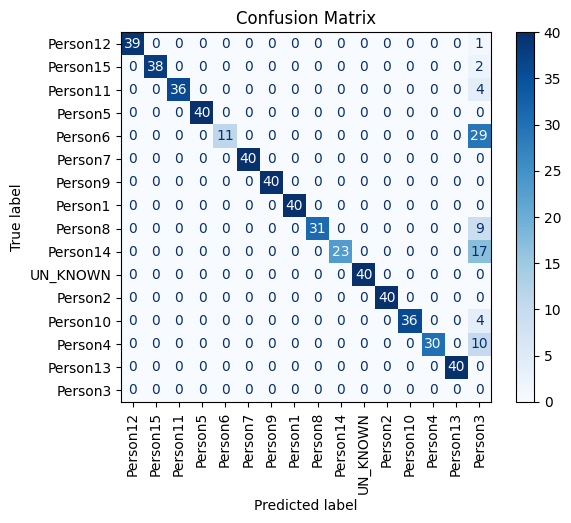

Accuracy: 0.8733333333333333
F1 Score: 0.9165567441038032
Precision: 1.0
Recall: 0.8733333333333333


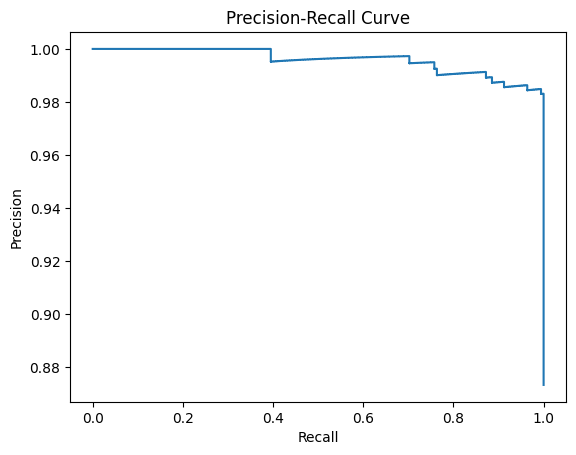

In [12]:
# Run the evaluation function
evaluate_on_test_images(max_images_per_class=50)
